## Import event log

In [53]:
import pm4py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [54]:
domestic_path = 'data/DomesticDeclarations.xes'
international_path = 'data/InternationalDeclarations.xes'

log= pm4py.read_xes(domestic_path);

parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

## Statistical Analysis of Event Data

In [55]:
# log

In [68]:
# to improve readability we trim the word 'Declaration' out of concept:name column, if it exists
log['concept:name'] = log['concept:name'].str.replace('Declaration ', '')

In [69]:
cases = log['case:id'].unique()
len(cases)

10500

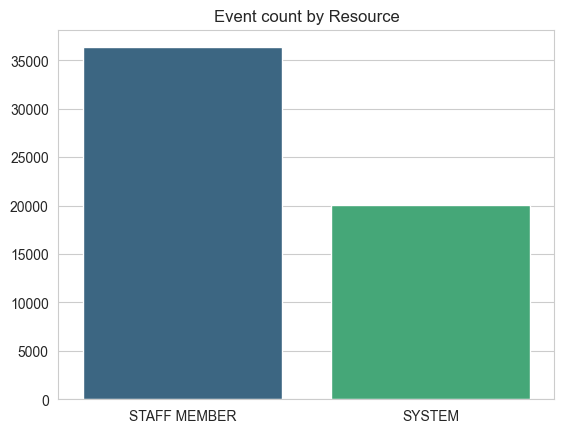

In [70]:
resources = log['org:resource'].unique()
sns.countplot(x='org:resource', data=log, palette='viridis').set(title='Event count by Resource', xlabel='', ylabel='');

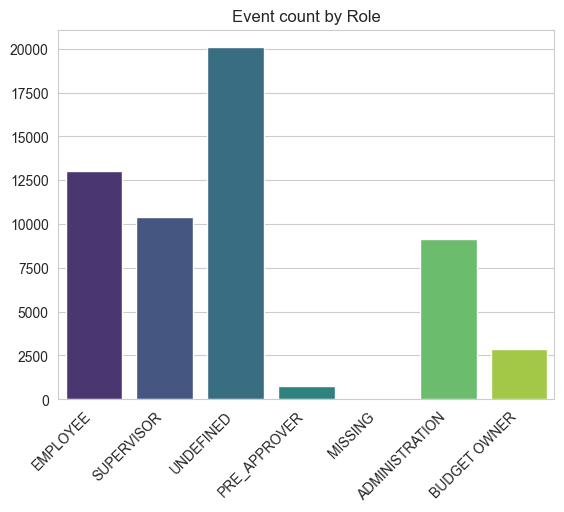

In [71]:
roles = log['org:role'].unique()
sns.countplot(x='org:role', data=log, palette='viridis').set(title='Event count by Role', xlabel='', ylabel='')
plt.xticks(rotation=45, ha='right');

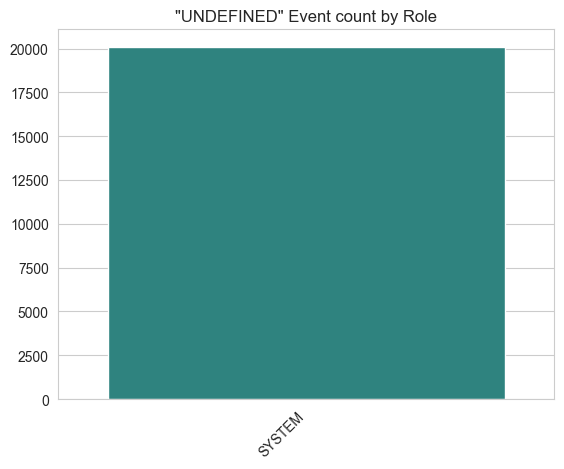

In [72]:
log_i = log[log['org:role'] == 'UNDEFINED']
sns.countplot(x='org:resource', data=log_i, palette='viridis').set(title='"UNDEFINED" Event count by Role', xlabel='', ylabel='')
plt.xticks(rotation=45, ha='right');

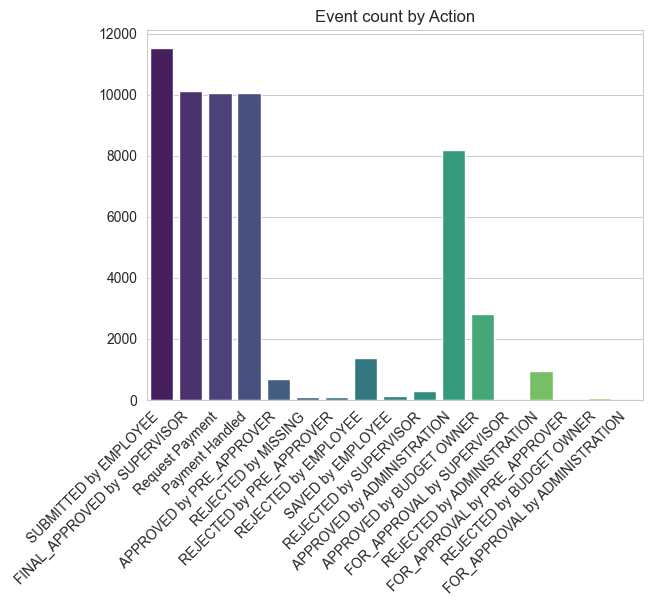

In [73]:
actions = log['concept:name'].unique()
sns.countplot(x='concept:name', data=log, palette='viridis').set(title='Event count by Action', xlabel='', ylabel='')
plt.xticks(rotation=45, ha='right');

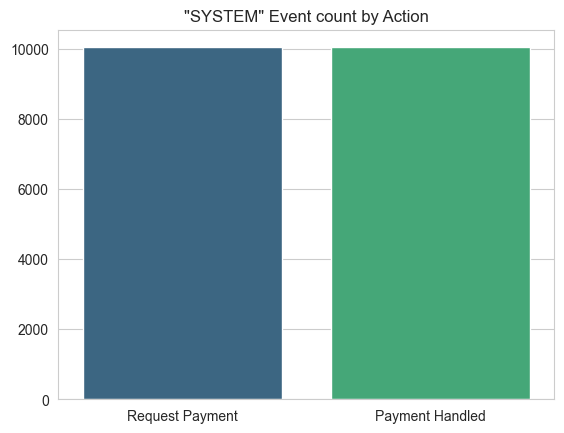

In [74]:
# System Events
log_s = log[log['org:resource'] == 'SYSTEM']
sns.countplot(x='concept:name', data=log_s, palette='viridis').set(title='"SYSTEM" Event count by Action', xlabel='', ylabel='');

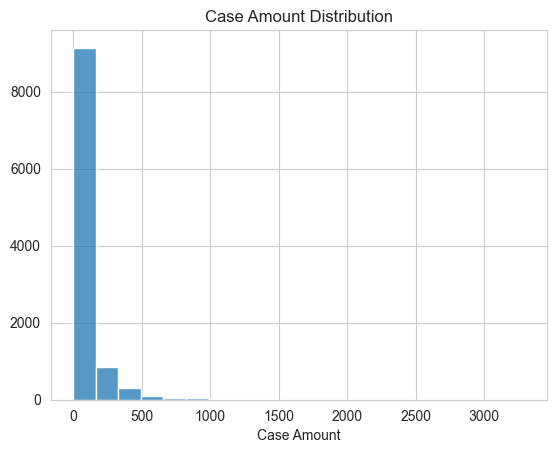

In [75]:
# case amount distribution for distinct case:id
distinct_case_amounts = log.groupby('case:id')['case:Amount'].max()
sns.histplot(distinct_case_amounts, kde=False, bins=20).set(title='Case Amount Distribution', xlabel='Case Amount', ylabel='');

## Process Discovery

Having mined the model we may vizualize it as a Process Tree or Petri Net.

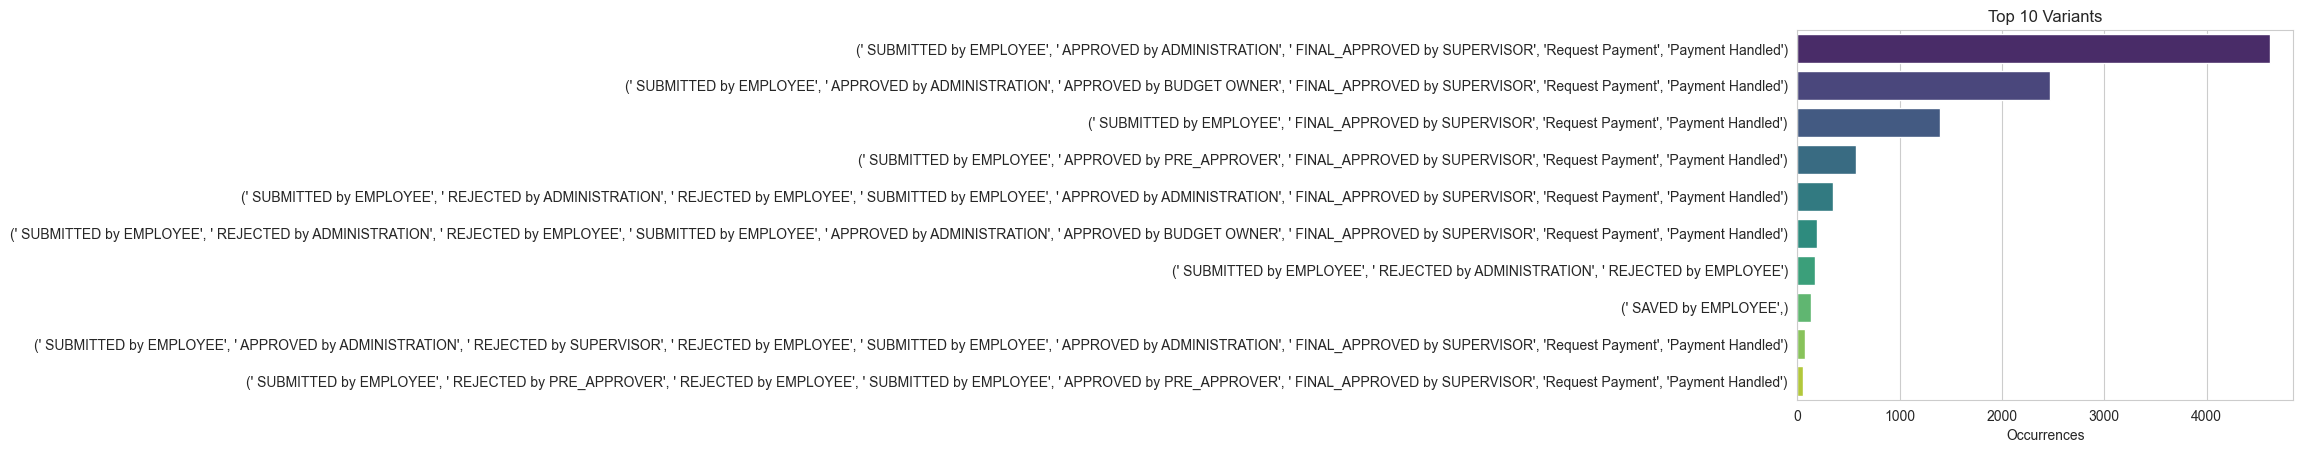

In [98]:
variants_dict = pm4py.get_variants(log)

variants_arr = []
idx = 1
for variant, n in variants_dict.items():
    variant_in_dict = {}
    variant_in_dict['variant_number'] = idx
    variant_in_dict['variant_count'] = n
    variant_in_dict['variant_trace'] = variant
    
    variants_arr.append(variant_in_dict)
    
    idx += 1


variants_df = pd.DataFrame(variants_arr)
variants_df = variants_df.sort_values(by='variant_count', ascending=False)

sns.barplot(x='variant_count', y='variant_trace', data=variants_df[:10], palette='viridis').set(title='Top 10 Variants', xlabel='Occurrences', ylabel='');

In [107]:
count_cases_top_10 = variants_df[:10]['variant_count'].sum()
print(f'Top 10 variants account for {count_cases_top_10:,} cases out of {len(cases):,}.')

Top 10 variants account for 10,033 cases out of 10,500.


In [104]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner

process_tree = inductive_miner.apply(log)
process_tree

->( X( tau, ' SAVED by EMPLOYEE' ), X( tau, +( X( tau, *( ' REJECTED by EMPLOYEE', tau ) ), ->( +( X( tau, *( ' REJECTED by MISSING', tau ) ), ->( X( tau, *( ->( *( ' SUBMITTED by EMPLOYEE', ' FOR_APPROVAL by ADMINISTRATION' ), X( tau, X( +( X( tau, ' REJECTED by BUDGET OWNER' ), ->( X( tau, X( ->( ' APPROVED by ADMINISTRATION', X( tau, ' APPROVED by BUDGET OWNER' ) ), ' APPROVED by PRE_APPROVER' ) ), X( tau, X( ' FINAL_APPROVED by SUPERVISOR', ' REJECTED by SUPERVISOR' ) ) ) ), ' REJECTED by PRE_APPROVER', ' REJECTED by ADMINISTRATION' ) ) ), tau ) ), X( tau, X( ' FOR_APPROVAL by PRE_APPROVER', 'Request Payment', ' FOR_APPROVAL by SUPERVISOR' ) ) ) ), X( tau, 'Payment Handled' ) ) ) ) )